In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates,
    MAMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.trainer.multioutput import TrainerEnsemble

In [3]:
from enum import Enum
UncertaintyMethod = Enum('UncertaintyMethod', 'pred_var MI pred_entropy KL pred_entropy_single')
uncertaintyMethod = "pred_entropy"
# uncertaintyMethod = "pred_var"
# uncertaintyMethod = "MI"
# uncertaintyMethod = "KL"

# uncertaintyMethod = "pred_entropy_single"


In [4]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:

config = {
	"training": False,
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 10,
	"removePolygons": True,
	"uncertainty_method": uncertaintyMethod
}
print(config)

'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
# dates = [2020, 2021]
# dataset = MAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	

# dates = [2018, 2019]

# dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
# dates = [2019, 2020]
dates = [2018, 2019]

dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
 	addPastDeforestationInput = config['addPastDeforestationInput'],
	borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = config['inference_times']


if config['training'] == False:

	if type(dataset) == PAMultipleDates:
		# exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		# exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140
trainer = TrainerEnsemble(config, dataset, patchesHandler)

trainer.defineExperiment(exp_ids)


{'training': False, 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'inference_times': 10, 'removePolygons': True, 'uncertainty_method': 'pred_entropy'}


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp_ids

[130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123]

In [7]:
# trainer.setExperimentPath()
# trainer.createLogFolders()

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:

trainer.loadLabel()

In [ ]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [ ]:

trainer.label_mask.dtype

dtype('uint8')

In [ ]:
unique, count = np.unique(trainer.label_mask, return_counts=True)
print(unique, count)

total = np.sum(count)
percentage_count = [round(x*100, 1) for x in count / total]
print(percentage_count)

[0 1 2] [99070749  1900166 74032985]
[56.6, 1.1, 42.3]


In [ ]:
# pdb.set_trace()

--Call--
> c:\users\jchamorro\anaconda3\envs\tf2\lib\site-packages\ipython\core\displayhook.py(252)__call__()
    250         sys.stdout.flush()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.
    254 



In [ ]:

trainer.getLabelCurrentDeforestation()

In [ ]:

trainer.loadInputImage()

ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [ ]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([114714828,   1054083,   1098901,   1007787,    876898,    648966,
           708581,    287191,    313901,    338545,    240796,   1332783,
         52380640], dtype=int64))

In [ ]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [ ]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [ ]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [ ]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [ ]:
if config["training"] == True:
    trainer.extractCoords()

In [ ]:
if config["training"] == True:
    trainer.trainTestSplit()

In [ ]:
if config["training"] == True:
    trainer.label_mask.shape

In [ ]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [ ]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [ ]:
if config["training"] == True:
    print(trainer.coords_train)

In [ ]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [ ]:
if config["training"] == True:
    inputSnipShow = True

In [ ]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [ ]:
'''
count, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [ ]:
'''
count, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [ ]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [ ]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [ ]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [ ]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [ ]:
if config["training"] == True:
    trainer.getGenerators()


In [ ]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [ ]:
if config["training"] == True:
    print(trainer.path_exp)

In [ ]:
if config["training"] == True:
    print(trainer.channels)

In [ ]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [ ]:
if config["training"] == True:
    trainer.train()

In [ ]:
if config["training"] == True:
    trainer.plotHistory()


In [ ]:
trainer.image_stack.shape

(17730, 9200, 21)

In [ ]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [ ]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]


In [ ]:
trainer.image_stack.shape

(17730, 9200, 21)

In [ ]:
trainer.setPadding()

-30.0 -16.0


In [ ]:
trainer.infer()

time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [ ]:
trainer.loadPredictedProbabilities()

In [ ]:
trainer.prob_rec.shape

(17760, 9216, 10)

In [ ]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [ ]:
trainer.prob_rec.shape

(17760, 9216, 10)

In [ ]:
trainer.getMeanProb()

In [ ]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 1.4644367e-15
    np.mean(value): 0.012334157
    np.max(value): 0.9999992


In [ ]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

In [ ]:
trainer.unpadMeanProb()

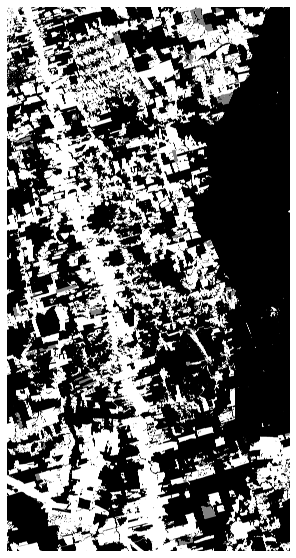

In [ ]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [ ]:
trainer.squeezeLabel()

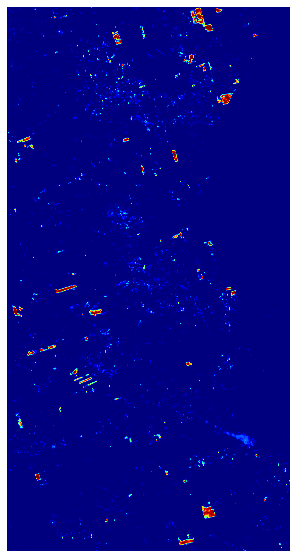

In [ ]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [ ]:
print(trainer.label_mask.shape)

(17730, 9200)


In [ ]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [ ]:
# trainer.getMAP()

In [ ]:
trainer.prob_rec.shape

(17760, 9216, 10)

In [ ]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(10, 17760, 9216, 1)


In [ ]:
trainer.prob_rec.shape

(10, 17760, 9216, 1)

In [ ]:
trainer.logger.getStats(trainer.prob_rec)

ic| np.min(value): 0.0
    np.mean(value): 0.012330051
    np.max(value): 1.0


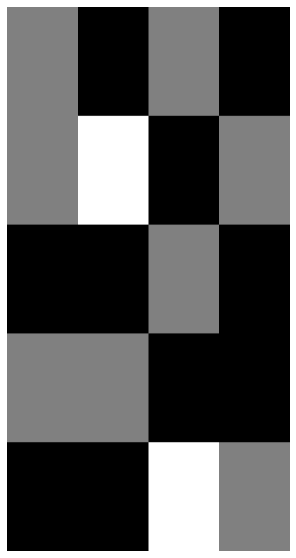

In [ ]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [ ]:
trainer.getLabelCurrentDeforestation()

In [ ]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [ ]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [ ]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161789622,   1326378], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([163001739,    114261], dtype=int64))


In [ ]:
trainer.calculateMetrics()

ic| self.f1: 81.41, self.precision: 97.07, self.recall: 70.1


In [ ]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9439113,)
ic| f1_val: 82.77
    precision_val: 89.56
    recall_val: 76.94
    mAP_val: 85.73


In [ ]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [ ]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162427946,    688054], dtype=int64))


In [ ]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


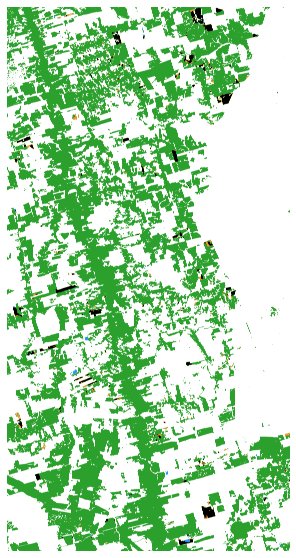

In [ ]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [ ]:
'''
import types

trainer.setUncertainty = types.MethodType(setUncertainty, trainer)
'''


'\nimport types\n\ntrainer.setUncertainty = types.MethodType(setUncertainty, trainer)\n'

In [ ]:
trainer.setUncertainty()

In [ ]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.009594776
    np.max(value): 0.36787948


ic| trainer.uncertainty_to_show.shape: (17730, 9200)


(17730, 9200)

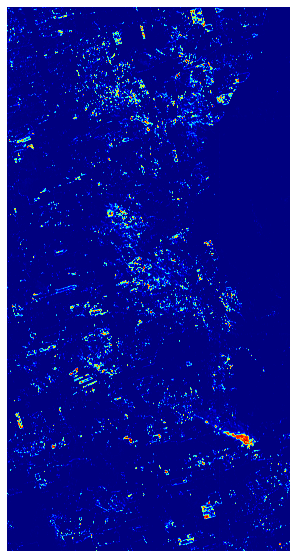

In [ ]:

trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty '+trainer.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(trainer.uncertainty_to_show.shape)



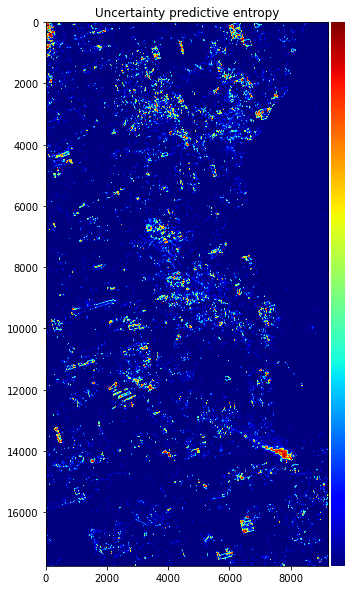

In [ ]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(trainer.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + trainer.title_name + ' uncertainty '+trainer.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

In [ ]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54181542,)


ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


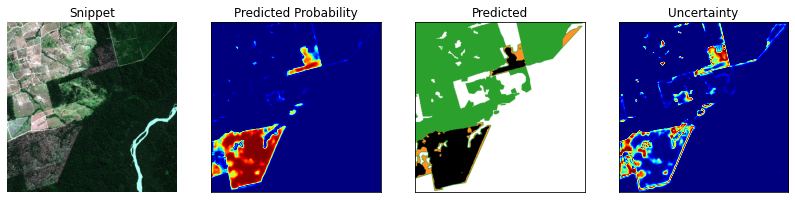

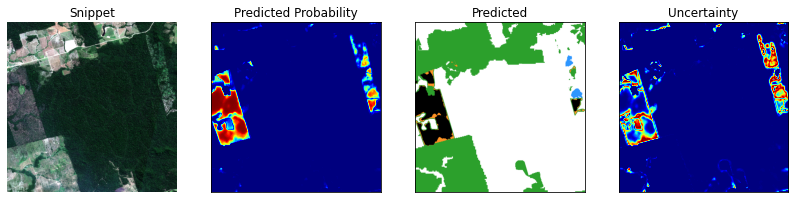

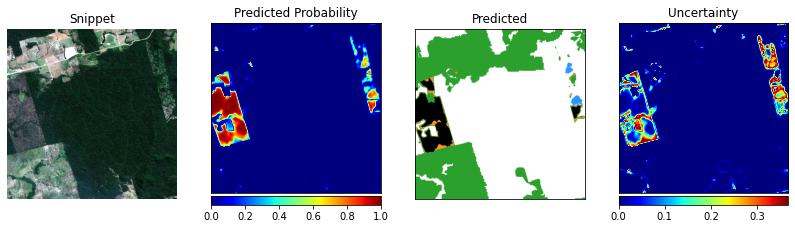

In [ ]:
trainer.logger.plotCropSample(trainer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


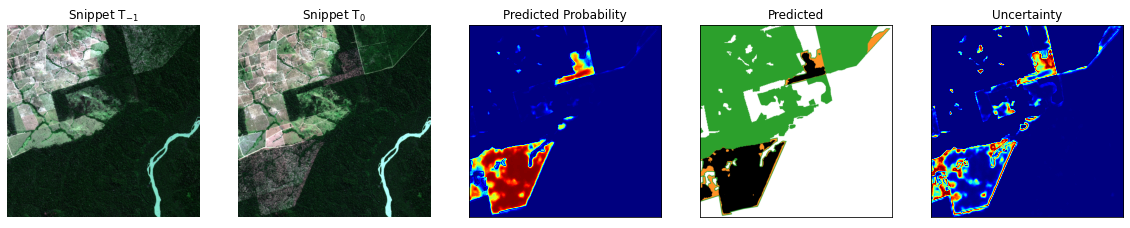

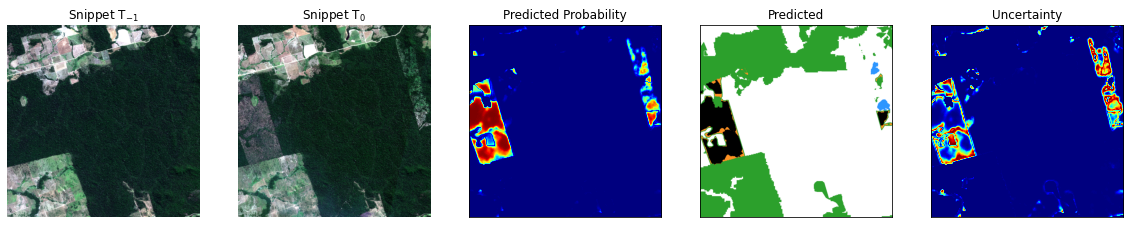

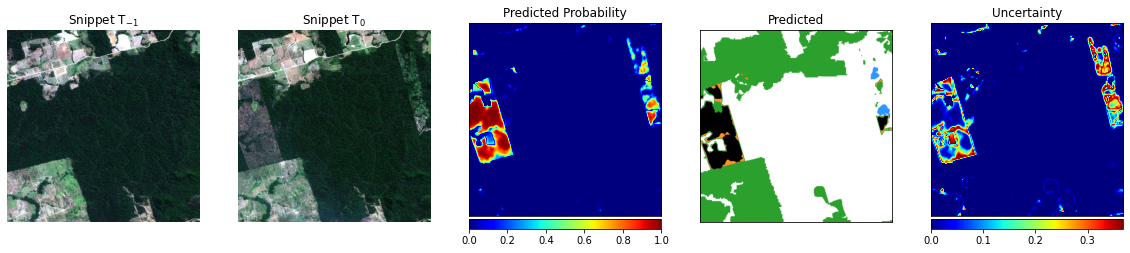

In [ ]:
trainer.logger.plotCropSampleT0T1(trainer)

In [ ]:
'''
dataset.previewLims1 = np.array([200, 700, 10200, 11200])
dataset.previewLims2 = np.array([2500, 3500, 6000, 7000])
'''

'\ndataset.previewLims1 = np.array([200, 700, 10200, 11200])\ndataset.previewLims2 = np.array([2500, 3500, 6000, 7000])\n'

In [ ]:
'''
import importlib
importlib.reload(_plt)
plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        importlib.reload(_plt)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1_.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2_.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims,
                colorbar = True)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertaintyColorbar_.png', dpi=150, bbox_inches='tight')
'''

"\nimport importlib\nimportlib.reload(_plt)\nplotCropSampleFlag = True\nif plotCropSampleFlag == True:\n        importlib.reload(_metrics)\n        importlib.reload(_plt)\n        # import matplotlib\n        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])\n        ic(dataset.previewLims1, dataset.previewLims2)\n        lims = dataset.previewLims1\n        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))\n        lims = dataset.previewLims2\n        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))\n\n        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, \n                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, \n                lims = dataset.previewLims1, \n                titles = ['Snippet $\\mathregular{T_{-1}}$', 'Snippet $\\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],\n                cmaps = [plt.cm.gray, plt.cm.gray

In [ ]:
trainer.logger.getStats(trainer.uncertainty)


ic| np.min(value): 2.024166e-08
    np.mean(value): 0.012984787
    np.max(value): 0.36787948


Get precision-recall threshold

In [ ]:

trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54181542,)
    self.label_mask_current_deforestation_test.shape: (54181542,)


[0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.0025
(43834924,) (43834924,)


ic| label_current_deforestation_test_classified_incorrect.shape: (10346618,)
    predicted_test_classified_incorrect.shape: (10346618,)


cm_correct [[43782889        0]
 [    2723    49312]]


ic| TP_H + FN_H + FP_H + TN_H: 10346618
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 10346618
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[9642135   15672]
 [ 218816  469995]]
[1.         0.94766984 0.06656174 0.19096204 0.96773098 0.68232795
 0.02265729]
threshold 0.005
(45911574,) (45911574,)


ic| label_current_deforestation_test_classified_incorrect.shape: (8269968,)
    predicted_test_classified_incorrect.shape: (8269968,)


cm_correct [[45828172        0]
 [    4198    79204]]


ic| TP_H + FN_H + FP_H + TN_H: 8269968
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 8269968
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[7596852   15672]
 [ 217341  440103]]
[1.         0.94966548 0.10691021 0.15263442 0.96561461 0.66941519
 0.02816151]
threshold 0.0075
(46959073,) (46959073,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7222469,)
    predicted_test_classified_incorrect.shape: (7222469,)


cm_correct [[46850536        0]
 [    5663   102874]]


ic| TP_H + FN_H + FP_H + TN_H: 7222469
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 7222469
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[6574488   15672]
 [ 215876  416433]]
[1.         0.94782424 0.13886017 0.13330128 0.96373104 0.65859097
 0.03203428]
threshold 0.01
(47661954,) (47661954,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6519588,)
    predicted_test_classified_incorrect.shape: (6519588,)


cm_correct [[47534595        0]
 [    6989   120370]]


ic| TP_H + FN_H + FP_H + TN_H: 6519588
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 6519588
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[5890429   15672]
 [ 214550  398937]]
[1.         0.94512363 0.16247641 0.12032858 0.96220053 0.65027784
 0.03527454]
threshold 0.015
(48587445,) (48587445,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5594097,)
    predicted_test_classified_incorrect.shape: (5594097,)


cm_correct [[48433725        0]
 [    9131   144589]]


ic| TP_H + FN_H + FP_H + TN_H: 5594097
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 5594097
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[4991299   15672]
 [ 212408  374718]]
[1.         0.94059979 0.19516742 0.10324728 0.95985553 0.63822416
 0.04070511]
threshold 0.025
(49636726,) (49636726,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4544816,)
    predicted_test_classified_incorrect.shape: (4544816,)


cm_correct [[49446997      104]
 [   12523   177102]]


ic| TP_H + FN_H + FP_H + TN_H: 4544816
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 4544816
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[3978027   15568]
 [ 209016  342205]]
[0.99941311 0.93395913 0.23905373 0.08388126 0.95648638 0.6208127
 0.04927851]
threshold 0.05
(50880233,) (50880233,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3301309,)
    predicted_test_classified_incorrect.shape: (3301309,)


cm_correct [[50629101      412]
 [   18744   231976]]


ic| TP_H + FN_H + FP_H + TN_H: 3301309
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 3301309
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[2795923   15260]
 [ 202795  287331]]
[0.9982271  0.92523931 0.31312311 0.06093051 0.94956889 0.58623905
 0.06567002]
threshold 0.08
(51634260,) (51634260,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2547282,)
    predicted_test_classified_incorrect.shape: (2547282,)


cm_correct [[51334577      681]
 [   24811   274191]]


ic| TP_H + FN_H + FP_H + TN_H: 2547282
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2547282
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[2090447   14991]
 [ 196728  245116]]
[0.99752248 0.91702062 0.37010526 0.04701383 0.94236603 0.55475688
 0.08229211]
threshold 0.1
(51967818,) (51967818,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2213724,)
    predicted_test_classified_incorrect.shape: (2213724,)


cm_correct [[51641451      833]
 [   28484   297050]]


ic| TP_H + FN_H + FP_H + TN_H: 2213724
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2213724
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[1783573   14839]
 [ 193055  222257]]
[0.9972036  0.91250069 0.40096052 0.04085753 0.93741354 0.5351567
 0.09268399]
threshold 0.15
(52535182,) (52535182,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1646360,)
    predicted_test_classified_incorrect.shape: (1646360,)
ic

cm_correct [[52151417     1360]
 [   38693   343712]]
cm_incorrect [[1273607   14312]
 [ 182846  175595]]


| TP_H + FN_H + FP_H + TN_H: 1646360
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1646360
    len(label_mask_current_deforestation_test): 54181542


[0.99605879 0.8988167  0.46394527 0.03038599 0.9246368  0.48988536
 0.11690968]
threshold 0.2
(52923864,) (52923864,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1257678,)
    predicted_test_classified_incorrect.shape: (1257678,)
ic| TP_H + FN_H + FP_H + TN_H: 1257678
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1257678
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52485024     2823]
 [   50654   385363]]
cm_incorrect [[940000  12849]
 [170885 133944]]
[0.99272771 0.88382563 0.52016613 0.0232123  0.91246858 0.43940701
 0.14013141]
threshold 0.225
(53087710,) (53087710,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1093832,)
    predicted_test_classified_incorrect.shape: (1093832,)
ic| TP_H + FN_H + FP_H + TN_H: 1093832
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1093832
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52620163     4068]
 [   57245   406234]]
cm_incorrect [[804861  11604]
 [164294 113073]]
[0.99008535 0.87648847 0.54833798 0.02018828 0.9069275  0.40766566
 0.15227352]
threshold 0.25
(53244806,) (53244806,)


ic| label_current_deforestation_test_classified_incorrect.shape: (936736,)
    predicted_test_classified_incorrect.shape: (936736,)
ic| TP_H + FN_H + FP_H + TN_H: 936736
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 936736
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52746368     5346]
 [   64610   428482]]
cm_incorrect [[678656  10326]
 [156929  90825]]
[0.98767714 0.86896969 0.57836851 0.01728884 0.897915   0.36659348
 0.16614317]
threshold 0.27
(53361569,) (53361569,)


ic| label_current_deforestation_test_classified_incorrect.shape: (819973,)
    predicted_test_classified_incorrect.shape: (819973,)
ic| TP_H + FN_H + FP_H + TN_H: 819973
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 819973
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52837540     6389]
 [   71322   446318]]
cm_incorrect [[587484   9283]
 [150217  72989]]
[0.98588712 0.86221698 0.60244369 0.01513381 0.88716696 0.32700286
 0.17767945]
threshold 0.3
(53527468,) (53527468,)


ic| label_current_deforestation_test_classified_incorrect.shape: (654074,)
    predicted_test_classified_incorrect.shape: (654074,)
ic| TP_H + FN_H + FP_H + TN_H: 654074
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 654074
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52961377     9015]
 [   83294   473782]]
cm_incorrect [[463647   6657]
 [138245  45525]]
[0.98132756 0.85048001 0.63951482 0.0120719  0.87242727 0.24772814
 0.19413893]
threshold 0.34
(53814193,) (53814193,)


ic| label_current_deforestation_test_classified_incorrect.shape: (367349,)
    predicted_test_classified_incorrect.shape: (367349,)
ic| TP_H + FN_H + FP_H + TN_H: 367349
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 367349
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53178586    14621]
 [  108662   512324]]
cm_incorrect [[246438   1051]
 [112877   6983]]
[0.97225327 0.82501699 0.69153913 0.00677997 0.86918098 0.05825964
 0.23220662]
threshold 0.36
(53993218,) (53993218,)


ic| label_current_deforestation_test_classified_incorrect.shape: (188324,)
    predicted_test_classified_incorrect.shape: (188324,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 188324
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 188324
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53300972    15672]
 [  157267   519307]]
cm_incorrect [[124052      0]
 [ 64272      0]]
[0.97070539 0.76755388 0.70096484 0.0034758         nan 0.
 0.17790917]
threshold 0.3648794801235199
(54066610,) (54066610,)


ic| label_current_deforestation_test_classified_incorrect.shape: (114932,)
    predicted_test_classified_incorrect.shape: (114932,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 114932
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 114932
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53349341    15672]
 [  182290   519307]]
cm_incorrect [[75683     0]
 [39249     0]]
[0.97070539 0.74017848 0.70096484 0.00212124        nan 0.
 0.12543865]
threshold 0.3663794801235199
(54100419,) (54100419,)


ic| label_current_deforestation_test_classified_incorrect.shape: (81123,)
    predicted_test_classified_incorrect.shape: (81123,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 81123
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 81123
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53371560    15672]
 [  193880   519307]]
cm_incorrect [[53464     0]
 [27659     0]]
[0.97070539 0.72814984 0.70096484 0.00149724        nan 0.
 0.09515438]


In [ ]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54181542,)
    self.label_mask_current_deforestation_test.shape: (54181542,)


threshold 0.0025
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    2723   738123]]
[1.         0.99632447]
threshold 0.005
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    4198   736648]]
[1.         0.99433351]
threshold 0.0075
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    5663   735183]]
[1.         0.99235604]
threshold 0.01
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    6989   733857]]
[1.         0.99056619]
threshold 0.015
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    9131   731715]]
[1.        0.9876749]
threshold 0.025
(54181542,) (54181542,)
cm_audited [[53440592      104]
 [   12523   728323]]
[0.99985723 0.98309635]
threshold 0.05
(54181542,) (54181542,)
cm_audited [[53440284      412]
 [   18744   722102]]
[0.99942977 0.9746992 ]
threshold 0.08
(54181542,) (54181542,)
cm_audited [[53440015      681]
 [   24811   716035]]
[0.99904983 0.96650991]
threshold 0.1
(54181542,) (54181542,)
cm_audited [[53439863

ic| metric_values_audited: array([[1.        , 0.99632447],
                                  [1.        , 0.99433351],
                                  [1.        , 0.99235604],
                                  [1.        , 0.99056619],
                                  [1.        , 0.9876749 ],
                                  [0.99985723, 0.98309635],
                                  [0.99942977, 0.9746992 ],
                                  [0.99904983, 0.96650991],
                                  [0.99883202, 0.96155206],
                                  [0.99806684, 0.94777187],
                                  [0.9959265 , 0.93162682],
                                  [0.99408436, 0.92273023],
                                  [0.99215648, 0.91278889],
                                  [0.9905476 , 0.90372898],
                                  [0.98647548, 0.88756908],
                                  [0.97739504, 0.85332714],
                                  [0.973

cm_audited [[53425024    15672]
 [  193880   546966]]
[0.9721455  0.73829919]


In [ ]:
trainer.setPlotLimsForUncertaintyAA()

In [ ]:
'''
import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
'''


'\nimport types\n\ntrainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)\n'

In [ ]:
trainer.xlim


[-0.1, 10.4]

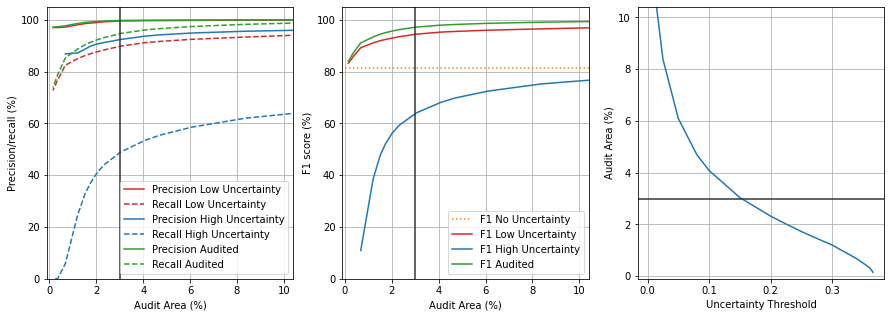

In [ ]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
trainer.plotUncertaintyAA()

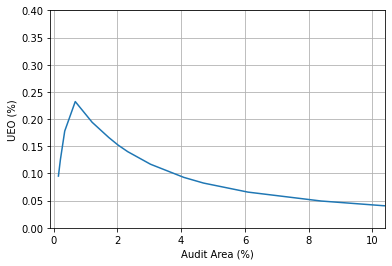

In [ ]:
trainer.plotUEO()

In [ ]:
trainer.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| bounds: (0.0015, 0.3663794801235199)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.1408715596097929
threshold 0.1408715596097929
(52450319,) (52450319,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1731223,)
    predicted_test_classified_incorrect.shape: (1731223,)
ic

cm_correct [[52076627     1217]
 [   36707   335768]]
cm_incorrect [[1348397   14455]
 [ 184832  183539]]


| TP_H + FN_H + FP_H + TN_H: 1731223
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1731223
    len(label_mask_current_deforestation_test): 54181542


[0.99638856 0.9014511  0.4532224  0.03195227 0.92699274 0.49824498
 0.11264581]
0.22700792051372695
threshold 0.22700792051372695
(53100692,) (53100692,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1080850,)
    predicted_test_classified_incorrect.shape: (1080850,)
ic| TP_H + FN_H + FP_H + TN_H: 1080850
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1080850
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52630750     4147]
 [   57816   407979]]
cm_incorrect [[794274  11525]
 [163723 111328]]
[0.98993754 0.87587673 0.5506934  0.01994868 0.9061887  0.40475403
 0.15334792]
0.08763636090393405
threshold 0.08763636090393405
(51772900,) (51772900,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2408642,)
    predicted_test_classified_incorrect.shape: (2408642,)


cm_correct [[51462518      737]
 [   26310   283335]]


ic| TP_H + FN_H + FP_H + TN_H: 2408642
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2408642
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[1962506   14935]
 [ 195229  235972]]
[0.99740559 0.91503173 0.3824479  0.04445503 0.94047595 0.54724363
 0.08628524]
0.16401704072386725
threshold 0.16401704072386725
(52656565,) (52656565,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1524977,)
    predicted_test_classified_incorrect.shape: (1524977,)
ic| TP_H + FN_H 

cm_correct [[52257171     1672]
 [   41902   355820]]
cm_incorrect [[1167853   14000]
 [ 179637  163487]]


+ FP_H + TN_H: 1524977
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1524977
    len(label_mask_current_deforestation_test): 54181542


[0.99532297 0.894645   0.48028875 0.02814569 0.92112098 0.47646623
 0.1234496 ]
0.15380089255642282
threshold 0.15380089255642282
(52569259,) (52569259,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1612283,)
    predicted_test_classified_incorrect.shape: (1612283,)
ic

cm_correct [[52181159     1438]
 [   39608   347054]]
cm_incorrect [[1243865   14234]
 [ 181931  172253]]


| TP_H + FN_H + FP_H + TN_H: 1612283
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1612283
    len(label_mask_current_deforestation_test): 54181542


[0.99587365 0.89756428 0.46845633 0.02975705 0.92367296 0.48633761
 0.1186485 ]
0.15261323206260033
threshold 0.15261323206260033
(52558738,) (52558738,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1622804,)
    predicted_test_classified_incorrect.shape: (1622804,)
ic

cm_correct [[52171985     1413]
 [   39338   346002]]
cm_incorrect [[1253039   14259]
 [ 182201  173305]]


| TP_H + FN_H + FP_H + TN_H: 1622804
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1622804
    len(label_mask_current_deforestation_test): 54181542


[0.99593282 0.89791353 0.46703633 0.02995123 0.92397795 0.48748826
 0.11809649]
0.14812831227039625
threshold 0.14812831227039625
(52518248,) (52518248,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1663294,)
    predicted_test_classified_incorrect.shape: (1663294,)
ic

cm_correct [[52136495     1325]
 [   38294   342134]]
cm_incorrect [[1288529   14347]
 [ 183245  177173]]


| TP_H + FN_H + FP_H + TN_H: 1663294
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1663294
    len(label_mask_current_deforestation_test): 54181542


[0.99614219 0.89933969 0.46181528 0.03069854 0.92508876 0.49157645
 0.11603176]
0.15170328989037926
threshold 0.15170328989037926
(52550590,) (52550590,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1630952,)
    predicted_test_classified_incorrect.shape: (1630952,)
ic

cm_correct [[52164908     1394]
 [   39101   345187]]
cm_incorrect [[1260116   14278]
 [ 182438  174120]]


| TP_H + FN_H + FP_H + TN_H: 1630952
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1630952
    len(label_mask_current_deforestation_test): 54181542


[0.99597785 0.89825079 0.46593624 0.03010162 0.92421363 0.4883357
 0.11769204]
0.15243317335660386
threshold 0.15243317335660386
(52557161,) (52557161,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624381,)
    predicted_test_classified_incorrect.shape: (1624381,)
ic

cm_correct [[52170614     1411]
 [   39293   345843]]
cm_incorrect [[1254410   14261]
 [ 182246  173464]]


| TP_H + FN_H + FP_H + TN_H: 1624381
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1624381
    len(label_mask_current_deforestation_test): 54181542


[0.99593669 0.8979763  0.46682171 0.02998034 0.92403249 0.48765567
 0.1180162 ]
0.15225472592389733
threshold 0.15225472592389733
(52555532,) (52555532,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1626010,)
    predicted_test_classified_incorrect.shape: (1626010,)
ic

cm_correct [[52169200     1407]
 [   39251   345674]]
cm_incorrect [[1255824   14265]
 [ 182288  173633]]


| TP_H + FN_H + FP_H + TN_H: 1626010
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1626010
    len(label_mask_current_deforestation_test): 54181542


[0.99594619 0.89802949 0.4665936  0.0300104  0.92408115 0.4878414
 0.11793171]
0.1522880615155332
threshold 0.1522880615155332
(52555814,) (52555814,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625728,)
    predicted_test_classified_incorrect.shape: (1625728,)
ic

cm_correct [[52169440     1407]
 [   39263   345704]]
cm_incorrect [[1255584   14265]
 [ 182276  173603]]


| TP_H + FN_H + FP_H + TN_H: 1625728
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1625728
    len(label_mask_current_deforestation_test): 54181542


[0.99594654 0.89800944 0.46663409 0.0300052  0.92406903 0.48781468
 0.11794361]
0.15232585578480035
threshold 0.15232585578480035
(52556179,) (52556179,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625363,)
    predicted_test_classified_incorrect.shape: (1625363,)
ic

cm_correct [[52169762     1409]
 [   39269   345739]]
cm_incorrect [[1255262   14263]
 [ 182270  173568]]


| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542


[0.99594121 0.89800472 0.46668133 0.02999846 0.92406472 0.48777253
 0.11796408]
0.1523668474496392
threshold 0.1523668474496392
(52556547,) (52556547,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624995,)
    predicted_test_classified_incorrect.shape: (1624995,)
ic

cm_correct [[52170073     1409]
 [   39283   345782]]
cm_incorrect [[1254951   14263]
 [ 182256  173525]]


| TP_H + FN_H + FP_H + TN_H: 1624995
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1624995
    len(label_mask_current_deforestation_test): 54181542
ic| self.threshold_optimal: 0.15232585578480035


[0.99594172 0.89798346 0.46673938 0.02999167 0.92404733 0.48772981
 0.11798075]


In [ ]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.15232585578480035
(52556179,) (52556179,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625363,)
    predicted_test_classified_incorrect.shape: (1625363,)
ic

cm_correct [[52169762     1409]
 [   39269   345739]]
cm_incorrect [[1255262   14263]
 [ 182270  173568]]


| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542


[0.99594121 0.89800472 0.46668133 0.02999846 0.92406472 0.48777253
 0.11796408]
threshold 0.15232585578480035
(54181542,) (54181542,)


ic| self.m_optimal: {'AA': array([0.02999846]),
                     'UEO': array([0.11796408]),
                     'f1': 81.41,
                     'f1_H': array([0.63850615]),
                     'f1_L': array([0.9444408]),
                     'precision_H': array([0.92406472]),
                     'precision_L': array([0.99594121]),
                     'recall_H': array([0.48777253]),
                     'recall_L': array([0.89800472]),
                     'recall_Ltotal': array([0.46668133])}
ic| self.m_audited_optimal: {'f1': array([0.97182636]),
                             'precision': array([0.99799569]),
                             'recall': array([0.94699438])}


cm_audited [[53439287     1409]
 [   39269   701577]]
[0.99799569 0.94699438]


{'metrics': {'precision_L': array([0.99594121]),
  'recall_L': array([0.89800472]),
  'recall_Ltotal': array([0.46668133]),
  'AA': array([0.02999846]),
  'precision_H': array([0.92406472]),
  'recall_H': array([0.48777253]),
  'UEO': array([0.11796408]),
  'f1_L': array([0.9444408]),
  'f1_H': array([0.63850615]),
  'f1': 81.41},
 'metrics_audited': {'precision': array([0.99799569]),
  'recall': array([0.94699438]),
  'f1': array([0.97182636])},
 'exp': 123}